In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from astroML.plotting import hist
from scipy import odr 
from sympy import *
import emcee
import corner
import scipy.stats as stats
from scipy.optimize import curve_fit

In [5]:
df=pd.read_csv('hardata.csv')
df[0:5]

,ClusterID,loggbar,dloggbar,loggobs,dloggobs
0,8625-12704,-9.45,0.08,-8.97,0.03
1,9181-12702,-9.57,0.09,-9.17,0.03
2,9492-9101,-9.72,0.09,-9.23,0.04
3,8258-3703,-8.97,0.10,-8.92,0.08
4,8331-12701,-9.85,0.09,-9.35,0.06


Text(0, 0.5, '$log[g_{obs}(m/s^2)]$')

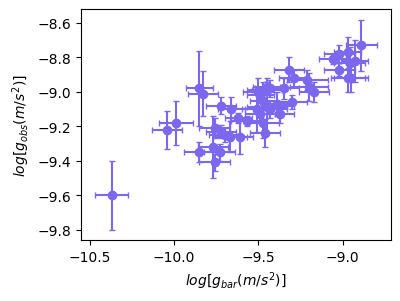

In [6]:
log_gb=df['loggbar'].to_numpy()
dlog_gb=df['dloggbar'].to_numpy()
log_go=df['loggobs'].to_numpy()
dlog_go=df['dloggobs'].to_numpy()

fig,ax=plt.subplots(figsize=(4,3))

ax.errorbar(log_gb,log_go,yerr=dlog_go,xerr=dlog_gb,fmt='o',capsize=2,color='mediumslateblue')
ax.set_xlabel('$log[g_{bar}(m/s^2)]$')
ax.set_ylabel('$log[g_{obs}(m/s^2)]$')

In [7]:
def line(theta,x):
    return theta[0]+theta[1]*x

def log_prior(theta):
    if ((-10 < theta[0] < 10) and (-10 < theta[1] < 10) and (-0.5< theta[2]<0.5)):
        return 0.0
    return -np.inf

def log_likelihood(theta, x,y,dx,dy):
    yM=line(theta,x)    
    sig2=theta[1]**2*dx**2+dy**2+np.power(10,theta[2])**2
    return -0.5 * (np.sum(2*np.pi*sig2)+np.sum(((y - yM)**2/sig2)))

def log_posterior(theta, x,y,dy):
    lp=log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,x,y,dy)

In [8]:
labels=['$c$','$m$', '$log\sigma_{int}$']

def main(x,y,xerr,yerr):
    
    p1=np.random.uniform(-10,10,50)
    p2=np.random.uniform(-10,10,50)
    p3=np.random.uniform(-0.5,0.5,50)
    pos=np.vstack((p1,p2,p3)).T
    
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x, y, xerr,yerr))
    sampler.run_mcmc(pos, 5000, progress=True)
    
    try:
        tau = sampler.get_autocorr_time()
        flat_samples = sampler.get_chain(discard=500, flat=True)
        
    except:
        flat_samples = sampler.get_chain(discard=500, flat=True)
        print('MCMC did not converge.')
        
    return flat_samples

100%|█████████████████████████████████████| 5000/5000 [00:03<00:00, 1277.42it/s]


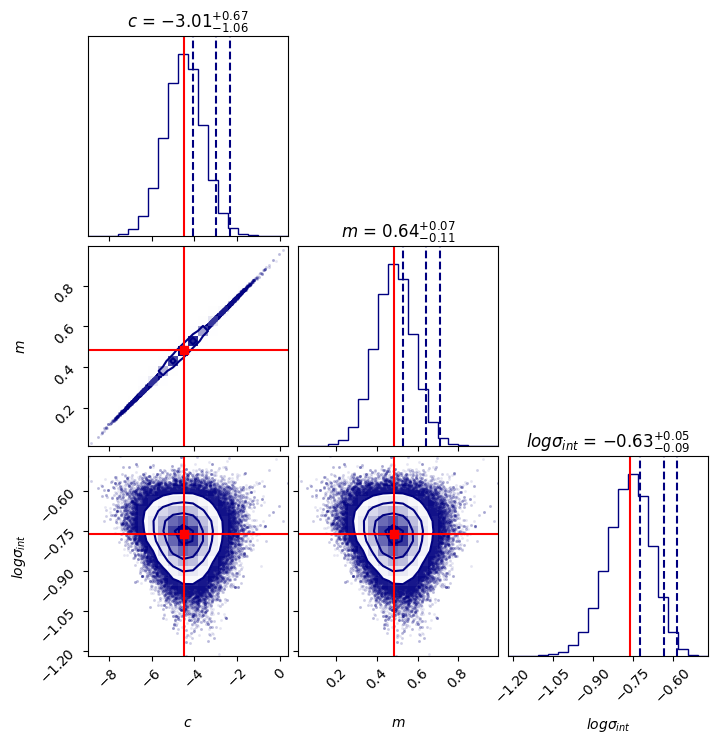

In [35]:
samples = main(log_gb,log_go,dlog_gb,dlog_go)
theta_max=np.median(samples,axis=0)
best_fit_model=line(theta_max,log_gb)
fig = corner.corner(samples,labels=labels,plot_datapoints=True,show_titles=True, 
                    use_math_text=True,truths=theta_max,color='navy',truth_color='red',
                    quantiles=[0.68,0.95,0.99])

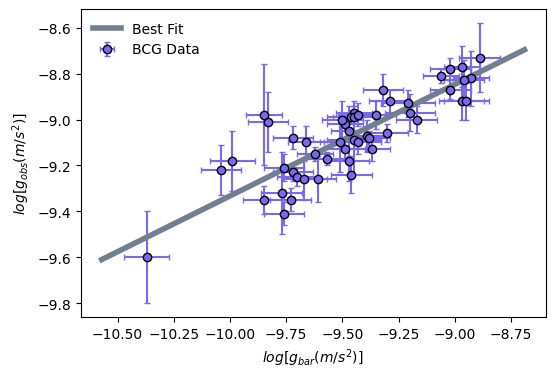

In [13]:
log_gb=df['loggbar'].to_numpy()
dlog_gb=df['dloggbar'].to_numpy()
log_go=df['loggobs'].to_numpy()
dlog_go=df['dloggobs'].to_numpy()

fig,ax=plt.subplots(figsize=(6,4))

xplot=np.linspace(min(log_gb)-0.2,max(log_gb)+0.2,10)
ax.errorbar(log_gb,log_go,yerr=dlog_go,xerr=dlog_gb,fmt='o',capsize=2,color='mediumslateblue',markeredgecolor='black',label='BCG Data')
ax.plot(xplot,line(theta_max,xplot),color='slategray',linewidth=4,zorder=2,label='Best Fit')
ax.set_xlabel('$log[g_{bar}(m/s^2)]$')
ax.set_ylabel('$log[g_{obs}(m/s^2)]$')
ax.legend(frameon=False)

In [ ]:
resids=(line(theta_max,log_gb)-log_go)
plt.figure(figsize=(5,4))
plt.hist(resids,bins=7,color='cornflowerblue',edgecolor='black',linewidth=2)
plt.xlim(-0.4,0.4)
plt.xlabel('Residuals(dex)',fontsize='large')
plt.ylabel('Measurements',fontsize='large')

## Interpolation functions

In [18]:
def nform(p,x):
    n,a0=p    
    return np.log10(((1+(1+4/(10**(x)/a0)**n)**0.5)/2)**(1/n)-1)+x

def bform(p,x):
    b,a0=p    
    return np.log10((1-np.exp(-(10**(x)/a0)))**(-0.5)+b*np.exp(-(10**(x)/a0))-1)+x

def gammaform(p,x):
    g,a0=p
    t1=(1-np.exp(-(10**(x)/a0)**g/2))
    t2=(1-(1/g))    
    return np.log10(t1**(-1/g)+t2*np.exp(-(10**(x)/a0)**g/2)-1)+x

def dform(p,x):
    d,a0=p
    t1=(1-np.exp(-(10**(x)/a0)**d/2))   
    return np.log10(t1**(-1/d)-1)+x

def eform(p,x):
    e,a0=p
    return np.log10(1/(np.tanh((10**x/a0)**(1/2/e)))**e-1)+x

def anform(p,x):
    a,n,a0=p
    return np.log10((1+((4*(10**x/a0)**(-a)+n**2)**0.5)/2)**(1/a)-1)+x

## HALO ACCELERATION RELATION

Text(0, 0.5, '$log[g_{obs}-g_{bar}(m/s^2)]$')

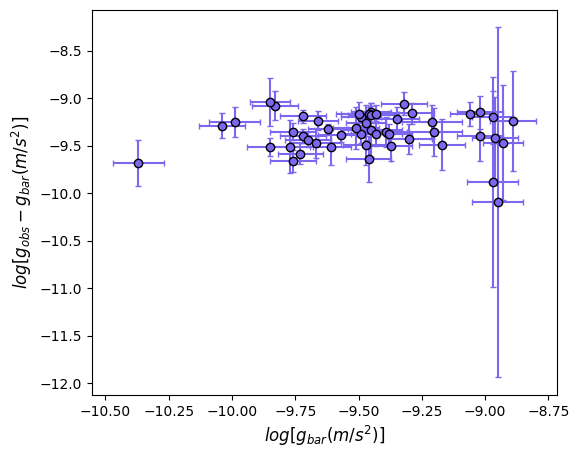

In [19]:
fig,ax=plt.subplots(figsize=(6,5))

y_har=np.log10(10**(log_go)-10**(log_gb))

#Errors from error propagation
dy_har=1/(10**(log_go)-10**(log_gb))*np.sqrt((10**(log_go)*dlog_go)**2+(10**(log_gb)*dlog_gb)**2)

ax.errorbar(log_gb,y_har,yerr=dy_har,xerr=dlog_gb,fmt='o',capsize=2,color='mediumslateblue',markeredgecolor='black')
ax.set_xlabel('$log[g_{bar}(m/s^2)]$',fontsize='large')
ax.set_ylabel('$log[g_{obs}-g_{bar}(m/s^2)]$',fontsize='large')

In [20]:
def diff_nform(p,x):
    n,a0=p
    r=symbols('r')
    expr= diff(log(((1+(1+4/(10**(r)/a0)**n)**0.5)/2)**(1/n)-1)/np.log(10)+r,r)
    return np.array([(expr.evalf(subs={r:x1})) for x1 in x]).astype(np.float64)

def diff_bform(p,x):
    b,a0=p    
    r=symbols('r')
    expr= diff(log((1-exp(-(10**(r)/a0)))**(-0.5)+b*exp(-(10**(r)/a0))-1)/np.log(10)+r,r)
    return np.array([np.float64(expr.evalf(subs={r:x1})) for x1 in x]).astype(np.float64)

def diff_gammaform(p,x):
    g,a0=p
    r=symbols('r')
    t1=(1-exp(-(10**(r)/a0)**g/2))
    t2=(1-(1/g))    
    expr=diff(log(t1**(-1/g)+t2*exp(-(10**(r)/a0)**g/2)-1)/np.log(10)+r,r)
    return np.array([np.float64(expr.evalf(subs={r:x1})) for x1 in x]).astype(np.float64)

def diff_dform(p,x):
    d,a0=p
    r=symbols('r')
    t1=(1-exp(-(10**(r)/a0)**d/2))   
    expr=diff(log(t1**(-1/d)-1)/np.log(10),r)
    return np.array([np.float64(expr.evalf(subs={r:x1})) for x1 in x]).astype(np.float64)

def diff_eform(p,x):
    e,a0=p
    r=symbols('r')
    expr=diff(log(1/(tanh((10**r/a0)**(1/2/e)))**e-1)/np.log(e)+r,r)
    return np.array([np.float64(expr.evalf(subs={r:x1})) for x1 in x]).astype(np.float64)

def diff_anform(p,x):
    a,n,a0=p
    r=symbols('r')
    expr= diff(log((1+((4*(10**r/a0)**(-a)+n**2)**0.5)/2)**(1/a)-1)/np.log(10)+r,r)
    return np.array([np.float64(expr.evalf(subs={r:x1})) for x1 in x]).astype(np.float64)

In [21]:
fns=[nform,bform,gammaform,dform,eform,anform]
data = odr.RealData(log_gb, y_har, sx=dlog_gb, sy=dy_har)
guesses=[1.16,2.82,1.04,1.16,1.56,(1.34,0.57)]

for (i,func) in enumerate(fns):
    odr_model = odr.Model(func)
    
    if i!=5:
        odr_reg = odr.ODR(data, odr_model,beta0=[guesses[i],2e-9])
    
    if i==5:
        odr_reg = odr.ODR(data, odr_model,beta0=[guesses[i][0],guesses[i][1],2e-9])

    out = odr_reg.run()
    print(func)
    out.pprint()
    print('\n')

<function nform at 0x29f8e7d80>
Beta: [1.33683501e+00 1.76661918e-09]
Beta Std Error: [6.01309171e-01 4.95691432e-10]
Beta Covariance: [[3.03293927e-01 2.43095393e-10]
 [2.43095393e-10 2.06106117e-19]]
Residual Variance: 1.1921528502042658
Inverse Condition #: 0.0816376285779294
Reason(s) for Halting:
  Sum of squares convergence


<function bform at 0x29f8e7c40>
Beta: [1.4172178e+00 8.0319387e-10]
Beta Std Error: [7.03763695e-01 3.20314980e-10]
Beta Covariance: [[ 4.27815638e-01 -1.92129723e-10]
 [-1.92129723e-10  8.86252425e-20]]
Residual Variance: 1.1577027454589823
Inverse Condition #: 0.06766202164217323
Reason(s) for Halting:
  Sum of squares convergence


<function gammaform at 0x29f56fc40>
Beta: [1.44969218e-01 5.28307014e-14]
Beta Std Error: [3.86828293e-02 1.68725296e-13]
Beta Covariance: [[1.24182178e-03 5.41528529e-15]
 [5.41528529e-15 2.36256195e-26]]
Residual Variance: 1.204972655765854
Inverse Condition #: 4.853476365789348e-05
Reason(s) for Halting:
  Sum of squares con

/var/folders/y0/6rp3f4hn0zxdj4vs7mnqf4080000gn/T/ipykernel_55760/1240408987.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10((1-np.exp(-(10**(x)/a0)))**(-0.5)+b*np.exp(-(10**(x)/a0))-1)+x
/var/folders/y0/6rp3f4hn0zxdj4vs7mnqf4080000gn/T/ipykernel_55760/1240408987.py:11: RuntimeWarning: invalid value encountered in power
  t1=(1-np.exp(-(10**(x)/a0)**g/2))
/var/folders/y0/6rp3f4hn0zxdj4vs7mnqf4080000gn/T/ipykernel_55760/1240408987.py:13: RuntimeWarning: invalid value encountered in power
  return np.log10(t1**(-1/g)+t2*np.exp(-(10**(x)/a0)**g/2)-1)+x
/var/folders/y0/6rp3f4hn0zxdj4vs7mnqf4080000gn/T/ipykernel_55760/1240408987.py:17: RuntimeWarning: invalid value encountered in power
  t1=(1-np.exp(-(10**(x)/a0)**d/2))


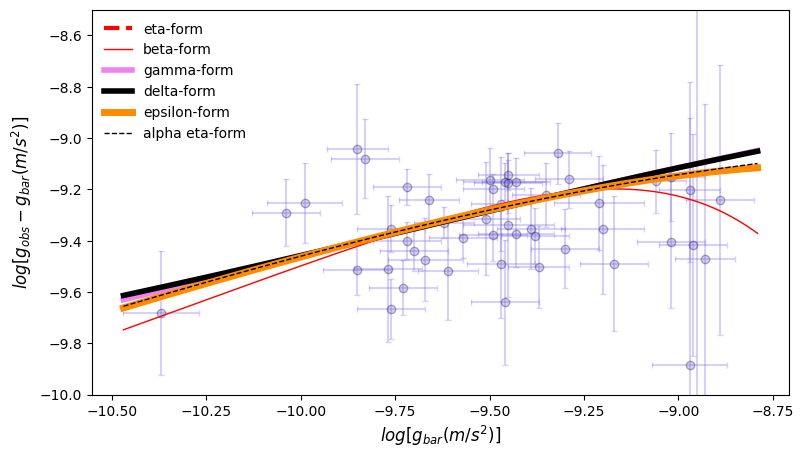

In [22]:
params=[[1.33686516e+00,1.76664517e-09],[1.41724030e+00,8.03182975e-10],
       [1.44962715e-01 ,5.28023699e-14],[2.32891095e-01 ,2.16240075e-12],
       [1.31781896e+00, 1.79012386e-09],[1.91685365e+00, 2.64783244e-04, 1.87388388e-09]]

xdata=np.linspace(log_gb.min()-0.1,log_gb.max()+0.1,500)
y1=nform(params[0],xdata)
y2=bform(params[1],xdata)
y3=gammaform(params[2],xdata)
y4=dform(params[3],xdata)
y5=eform(params[4],xdata)
y6=anform(params[5],xdata)

fig,ax=plt.subplots(figsize=(9,5))


'''
ax.plot(xdata,y1,'--',linewidth=3,color='red',label='$\eta$-form',zorder=2)
ax.plot(xdata,y2,'.-',linewidth=3,color='green',label='$\beta-form$',zorder=2)
ax.plot(xdata,y3,linewidth=3,color='gray',label='$\gamma-form$',zorder=2)
ax.plot(xdata,y4,'--',linewidth=3,color='black',label='$\delta-form$',zorder=2)
ax.plot(xdata,y5,'.-',linewidth=3,color='orange',label='$\epsilon-form$',zorder=2)
ax.plot(xdata,y6,'--',linewidth=3,color='blue',label='$\alpha \eta-form$',zorder=2)
'''

ax.plot(xdata,y1,'--',linewidth=3,color='red',label='eta-form',zorder=2)
ax.plot(xdata,y2,linewidth=1,markersize=1,color='red',label='beta-form',zorder=2)
ax.plot(xdata,y3,linewidth=4,color='violet',label='gamma-form',zorder=2)
ax.plot(xdata,y4,linewidth=4,color='black',label='delta-form',zorder=2)
ax.plot(xdata,y5,linewidth=5,color='darkorange',label='epsilon-form',zorder=2)
ax.plot(xdata,y6,'--',linewidth=1,color='black',label='alpha eta-form',zorder=2)


ax.set_ylim(-10,-8.5)
ax.errorbar(log_gb,y_har,yerr=dy_har,xerr=dlog_gb,fmt='o',capsize=2,color='mediumslateblue',markeredgecolor='black',zorder=1,alpha=0.3)
ax.set_xlabel('$log[g_{bar}(m/s^2)]$',fontsize='large')
ax.set_ylabel('$log[g_{obs}-g_{bar}(m/s^2)]$',fontsize='large')
ax.legend(frameon=False)

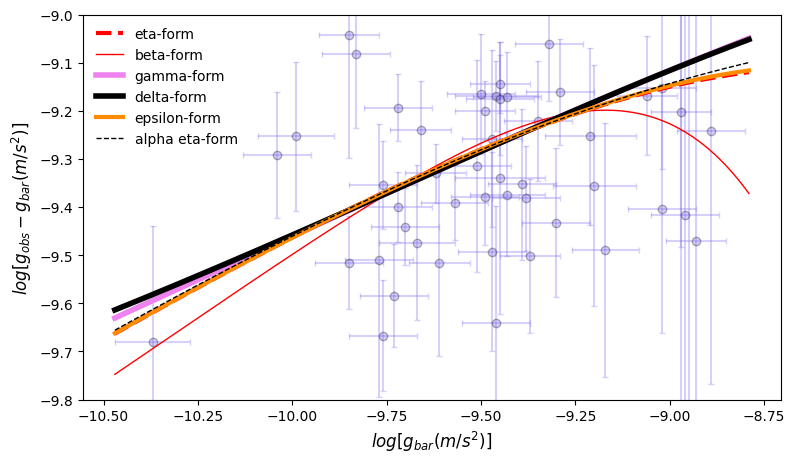

In [23]:
params=[[1.33686516e+00,1.76664517e-09],[1.41724030e+00,8.03182975e-10],
       [1.44962715e-01 ,5.28023699e-14],[2.32891095e-01 ,2.16240075e-12],
       [1.31781896e+00, 1.79012386e-09],[1.91685365e+00, 2.64783244e-04, 1.87388388e-09]]

xdata=np.linspace(log_gb.min()-0.1,log_gb.max()+0.1,500)
y1=nform(params[0],xdata)
y2=bform(params[1],xdata)
y3=gammaform(params[2],xdata)
y4=dform(params[3],xdata)
y5=eform(params[4],xdata)
y6=anform(params[5],xdata)

fig,ax=plt.subplots(figsize=(9,5))


ax.plot(xdata,y1,'--',linewidth=3,color='red',label='eta-form',zorder=2)
ax.plot(xdata,y2,linewidth=1,markersize=1,color='red',label='beta-form',zorder=2)
ax.plot(xdata,y3,linewidth=4,color='violet',label='gamma-form',zorder=2)
ax.plot(xdata,y4,linewidth=4,color='black',label='delta-form',zorder=2)
ax.plot(xdata,y5,linewidth=3,color='darkorange',label='epsilon-form',zorder=2)
ax.plot(xdata,y6,'--',linewidth=1,color='black',label='alpha eta-form',zorder=2)


ax.set_ylim(-9.8,-9)
ax.errorbar(log_gb,y_har,yerr=dy_har,xerr=dlog_gb,fmt='o',capsize=2,color='mediumslateblue',markeredgecolor='black',zorder=1,alpha=0.3)
ax.set_xlabel('$log[g_{bar}(m/s^2)]$',fontsize='large')
ax.set_ylabel('$log[g_{obs}-g_{bar}(m/s^2)]$',fontsize='large')
ax.legend(frameon=False)

In [24]:
import scipy.stats as stats

diff_fns=[diff_nform,diff_bform,diff_gammaform,diff_dform,diff_eform,diff_anform]
data=(log_gb, y_har, dlog_gb, dy_har)

def compute_chi2(model,theta,diff_fn):
    print(diff_fn(theta, log_gb)[0:5])
    print(dy_har[0:5])
    err=np.sqrt(dy_har**2+(diff_fn(theta, log_gb)**2)*dlog_gb**2)
    print(err[0:5])
    resid = (y_har - model(theta, log_gb)) / err
    return np.sum(resid ** 2)

def compute_dof(theta):
    return 50 - len(theta)

def chi2_likelihood( model, theta, diff_fn):
    chi2 = compute_chi2(model, theta,diff_fn)
    dof = compute_dof(theta)
    print('Done')
    return stats.chi2(dof).pdf(chi2)

[0.31331385 0.3379362  0.36409885 0.1731419  0.38322279]
[0.05983508 0.07763966 0.07314986 1.10128254 0.09711981]
[0.06487292 0.08338432 0.08015424 1.10141864 0.10306222]
Done
[0.31331385 0.3379362  0.36409885 0.1731419  0.38322279]
[0.05983508 0.07763966 0.07314986 1.10128254 0.09711981]
[0.06487292 0.08338432 0.08015424 1.10141864 0.10306222]
[ 0.32602118  0.4022093   0.46412497 -0.44104164  0.49685154]
[0.05983508 0.07763966 0.07314986 1.10128254 0.09711981]
[0.06527244 0.08566372 0.08423621 1.10216533 0.10691976]
Done
[ 0.32602118  0.4022093   0.46412497 -0.44104164  0.49685154]
[0.05983508 0.07763966 0.07314986 1.10128254 0.09711981]
[0.06527244 0.08566372 0.08423621 1.10216533 0.10691976]
[0.34476917 0.34914821 0.35373109 0.32164625 0.35687103]
[0.05983508 0.07763966 0.07314986 1.10128254 0.09711981]
[0.06588609 0.08375765 0.07977731 1.10175215 0.10229296]
Done
[0.34476917 0.34914821 0.35373109 0.32164625 0.35687103]
[0.05983508 0.07763966 0.07314986 1.10128254 0.09711981]
[0.065

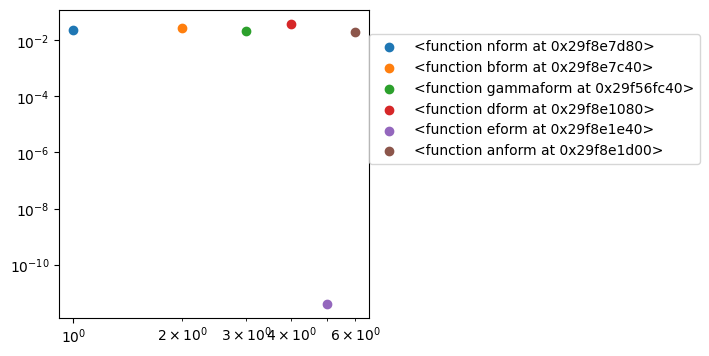

In [32]:
chi2s1=[]
chi = []
x=[1,2,3,4,5,6]
plt.figure(figsize=(4,4))
fns=[nform,bform,gammaform,dform,eform,anform]
for (i,func) in enumerate(fns):
    theta=params[i]
    chi2s1.append(chi2_likelihood(func,theta,diff_fns[i]))
    chi.append(compute_chi2(func, theta, diff_fns[i]))
    plt.scatter(x[i],chi2s1[i],label=str(func))
    
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=(1,0.5))

BIC = []
AIC = []
chi = np.array(chi)
Log_L = chi/2
for i in range(len(chi)):
    if i!=5:
        BIC.append(2*np.log(len(log_gb)) - 2*Log_L[i])
        AIC.append(2*2 - 2*Log_L[i])
    else:
        BIC.append(3*np.log(len(log_gb)) - 2*Log_L[i])
        AIC.append(2*3 - 2*Log_L[i])
        print('yep')
AIC = np.array(AIC)
BIC = np.array(BIC)
d_AIC = AIC - np.array([min(AIC)]*6)
d_BIC = BIC - np.array([min(BIC)]*6)
print('result')
print(AIC)
print(BIC)
print('diff')
print(d_AIC)
print(d_BIC)

In [39]:
chi2s1
for i in chi:
    print(i/(50-3))

1.2166668823455795
1.1805226678821084
1.2304157825253457
1.044230074508415
0.15477644352767492
1.22160493566574


## BINNED DATA

In [ ]:
fig,ax=plt.subplots(figsize=(4,4))
hist(log_gb,bins='freedman',color='cornflowerblue')

In [ ]:
bins=[]
bin_starts=[-10.37      , -10.15284659,  -9.93569318,  -9.71853977,
         -9.50138636,  -9.28423295,  -9.06707954,  -8.84992613    ]
for i in range(len(bin_starts)-1):
    data=df[(df['loggbar']>=bin_starts[i]) & (df['loggbar']<=bin_starts[i+1])]
    bins.append(data)

In [ ]:
binned=[]

for data in bins:
    
    x=data['loggbar'].to_numpy()
    dx=data['dloggbar'].to_numpy()
    y=data['loggobs'].to_numpy()
    dy=data['dloggobs'].to_numpy()
    
    x2=np.average(x,weights=1/dx/dx)
    dx2=np.sqrt(np.sum(np.std(x)**2+dx**2)/len(x))
    y2=np.average(y,weights=1/dy/dy)
    dy2=np.sqrt(np.sum(np.std(y)**2+dy**2)/len(y))
    
    binned.append([x2,dx2,y2,dy2])
    
binned=np.array(binned)
binned

In [ ]:
xfin=binned[:,0]
yfin=binned[:,2]
dxfin=binned[:,1]
dyfin=binned[:,3]

fig,ax=plt.subplots(figsize=(6,5))

ax.errorbar(xfin,yfin,yerr=dyfin,xerr=dxfin,fmt='o',capsize=2,color='mediumslateblue',markeredgecolor='black',label='Binned Data')

ax.legend()
ax.set_xlabel('$log[g_{bar}(m/s^2)]$',fontsize='large')
ax.set_ylabel('$log[g_{obs}-g_{bar}(m/s^2)]$',fontsize='large')

In [ ]:
data2 = odr.RealData(xfin, yfin, sx=dxfin, sy=dyfin)
guesses=[1.16,2.82,1.04,1.16,1.56,(1.34,0.57)]

for (i,func) in enumerate(fns):
    odr_model = odr.Model(func)
    
    if i!=5:
        odr_reg = odr.ODR(data2, odr_model,beta0=[guesses[i],2e-9])
    
    if i==5:
        odr_reg = odr.ODR(data2, odr_model,beta0=[guesses[i][0],guesses[i][1],2e-9])

    out = odr_reg.run()
    print(func)
    out.pprint()
    print('\n')

In [ ]:
params=[[8.33206241e-01, 2.49846315e-09],[8.56627411e-01 ,2.52003447e-09],
       [1.08013514e-01 ,1.74135468e-15],[1.65600188e-01,2.25710465e-13],
       [2.07995601e+00 ,2.59466161e-09],[2.11231653e+00, 7.77666709e+00, 3.54171618e-09]]

xdata2=np.linspace(xfin.min()-0.1,xfin.max()+0.1,500)
y11=nform(params[0],xdata2)
y12=bform(params[1],xdata2)
y13=gammaform(params[2],xdata2)
y14=dform(params[3],xdata2)
y15=eform(params[4],xdata2)
y16=anform(params[5],xdata2)

fig,ax=plt.subplots(figsize=(6,4))

'''
ax.plot(xdata,y1,'--',linewidth=3,color='red',label='$\eta-form$',zorder=2)
ax.plot(xdata,y2,'.-',linewidth=3,color='green',label='$\beta-form$',zorder=2)
ax.plot(xdata,y3,linewidth=3,color='gray',label='$\gamma-form$',zorder=2)
ax.plot(xdata,y4,'--',linewidth=3,color='black',label='$\delta-form$',zorder=2)
ax.plot(xdata,y5,'.-',linewidth=3,color='orange',label='$\epsilon-form$',zorder=2)
ax.plot(xdata,y6,'--',linewidth=3,color='blue',label='$\alpha \eta-form$',zorder=2)
'''

ax.plot(xdata2,y11,'--',linewidth=1,color='red',label='eta-form',zorder=2)
ax.plot(xdata2,y12,linewidth=1,markersize=1,color='red',label='beta-form',zorder=2)
ax.plot(xdata2,y13,linewidth=1,color='violet',label='gamma-form',zorder=2)
ax.plot(xdata2,y14,linewidth=1,color='black',label='delta-form',zorder=2)
ax.plot(xdata2,y15,linewidth=1,color='darkorange',label='epsilon-form',zorder=2)
ax.plot(xdata2,y16,'--',linewidth=1,color='black',label='alpha eta-form',zorder=2)


ax.set_ylim(-9.9,-8.7)
ax.errorbar(xfin,yfin,yerr=dyfin,xerr=dxfin,fmt='o',capsize=2,color='mediumslateblue',markeredgecolor='black',zorder=1,alpha=0.5)
ax.set_xlabel('$log[g_{bar}(m/s^2)]$',fontsize='large')
ax.set_ylabel('$log[g_{obs}-g_{bar}(m/s^2)]$',fontsize='large')
ax.legend(frameon=False)

In [ ]:
def compute_chi2(model,theta,diff_fn):
    print(diff_fn(theta, xfin)[0:5])
    print(dyfin[0:5])
    err=np.sqrt(dyfin**2+diff_fn(theta, xfin)**2*dxfin**2)
    print(err[0:5])
    resid = (yfin - model(theta, xfin)) / err
    return np.sum(resid ** 2)

def compute_dof(theta):
    return 7 - len(theta)

def chi2_likelihood( model, theta, diff_fn):
    chi2 = compute_chi2(model, theta,diff_fn)
    dof = compute_dof(theta)
    print('Done')
    return stats.chi2(dof).pdf(chi2)

chi2s2=[]
x=[1,2,3,4,5,6]
plt.figure(figsize=(4,4))
fns=[nform,bform,gammaform,dform,eform,anform]
for (i,func) in enumerate(fns):
    theta=params[i]
    chi2s2.append(chi2_likelihood(func,theta,diff_fns[i]))
    plt.scatter(x[i],chi2s2[i],label=str(func))
    
plt.legend(loc=(1,0.5))

In [ ]:
plt.scatter(x,chi2s1)
plt.scatter(x,chi2s2)
plt.xscale('log')
plt.yscale('log')